In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

from lib.data.datareader_total import DataReaderTotal
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_fit3d import DataReaderFIT3D
from lib.utils.args import get_opts_args
from lib.model.load_model import load_model
from lib.model.load_dataset import load_dataset
from lib.data.dataset_motion_3d import MotionDataset3DTotal
from lib.model.evaluation import *

In [7]:
dataset_name = 'h36m'
overwrite_list = []
source_list                    = load_data(dataset_name=dataset_name, data_type='source_list', overwrite_list=overwrite_list)
cam_params                     = load_data(dataset_name=dataset_name, data_type='cam_param', overwrite_list=overwrite_list)
world_3ds                      = load_data(dataset_name=dataset_name, data_type='world_3d', overwrite_list=overwrite_list)
cam_3ds                        = load_data(dataset_name=dataset_name, data_type='cam_3d', overwrite_list=overwrite_list)
img_2ds                        = load_data(dataset_name=dataset_name, data_type='img_2d', overwrite_list=overwrite_list)
img_3ds                        = load_data(dataset_name=dataset_name, data_type='img_3d', overwrite_list=overwrite_list)
scale_factors                  = load_data(dataset_name=dataset_name, data_type='scale_factor', overwrite_list=overwrite_list)
img_25ds                       = load_data(dataset_name=dataset_name, data_type='img_25d', overwrite_list=overwrite_list)
cam_3d_canonicals_same_z       = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
cam_3d_canonicals_same_dist    = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
cam_3d_canonicals_fixed_dist_5 = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)
img_2d_canonicals_same_z       = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
img_2d_canonicals_same_dist    = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
img_2d_canonicals_fixed_dist_5 = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)

==> Loading H36M source_list... overwrite: False
==> Loading H36M cam_param... overwrite: False
==> Loading H36M world_3d... overwrite: False
==> Loading H36M cam_3d... overwrite: False
==> Loading H36M img_2d... overwrite: False
==> Loading H36M img_3d... overwrite: False
==> Loading H36M scale_factor... overwrite: False
==> Loading H36M img_25d... overwrite: False
==> Loading H36M cam_3d_canonical_same_z... overwrite: False
==> Loading H36M cam_3d_canonical_same_dist... overwrite: False
==> Loading H36M cam_3d_canonical_fixed_dist_5... overwrite: False
==> Loading H36M img_2d_canonical_same_z... overwrite: False
==> Loading H36M img_2d_canonical_same_dist... overwrite: False
==> Loading H36M img_2d_canonical_fixed_dist_5... overwrite: False


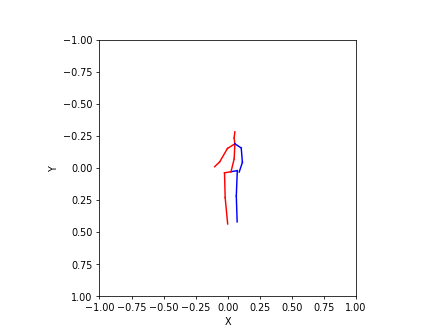

In [8]:
source = source_list[0]
subject, cam_id, action = split_source_name(source, dataset_name)
cam_param = cam_params[subject][action][cam_id]
W, H, R, t, C, intrinsic, extrinsic = cam_param['W'], cam_param['H'], cam_param['R'], cam_param['t'], cam_param['C'], cam_param['intrinsic'], cam_param['extrinsic']
fx, fy, cx, cy = intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2]

frame_num = 0
img_2d_canonical_fixed_dist_5 = img_2d_canonicals_fixed_dist_5[subject][action][cam_id]
img_2d_canonical_fixed_dist_5_norm = normalize_input(img_2d_canonical_fixed_dist_5, W, H)

fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig)
draw_2d_pose(ax, img_2d_canonical_fixed_dist_5_norm[frame_num], normalize=True)
plt.show()

In [9]:
data_type = 'img_2d_canonicals_fixed_dist_5'
save_folder = f'/home/{user}/codes/MotionBERT/videos/{dataset_name}/{data_type}'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [10]:
random.shuffle(source_list)
source_list[:20]

['S6_60457274_WalkDog 1',
 'S11_58860488_Photo 1',
 'S9_58860488_Waiting',
 'S5_55011271_Posing',
 'S5_55011271_WalkTogether',
 'S9_60457274_WalkTogether',
 'S11_55011271_Sitting',
 'S5_58860488_WalkDog',
 'S8_60457274_WalkTogether 2',
 'S6_54138969_Posing 2',
 'S8_60457274_Sitting 1',
 'S6_58860488_Discussion 1',
 'S7_58860488_Discussion',
 'S11_54138969_SittingDown 1',
 'S1_54138969_Smoking',
 'S6_58860488_Waiting 3',
 'S7_60457274_SittingDown 1',
 'S5_55011271_Purchases 1',
 'S5_58860488_Posing 1',
 'S9_60457274_Walking 1']

In [11]:
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig)

for source in source_list[:20]:
    #if 'TS' not in source: continue
    subject, cam_id, action = split_source_name(source, dataset_name)
    save_path = os.path.join(save_folder, f'{subject}_{cam_id}_{action}.mp4')
    if os.path.exists(save_path): continue
    
    cam_param = cam_params[subject][action][cam_id]
    W, H, R, t, C, intrinsic, extrinsic = cam_param['W'], cam_param['H'], cam_param['R'], cam_param['t'], cam_param['C'], cam_param['intrinsic'], cam_param['extrinsic']
    fx, fy, cx, cy = intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2]

    img_2d_canonical_fixed_dist_5 = img_2d_canonicals_fixed_dist_5[subject][action][cam_id]
    img_2d_canonical_fixed_dist_5_norm = normalize_input(img_2d_canonical_fixed_dist_5, W, H)
    
    videowriter = imageio.get_writer(save_path, fps=6)
    for frame_num in tqdm(range(0, len(img_2d_canonical_fixed_dist_5_norm), 5)):
        clear_axes(ax)
        draw_2d_pose(ax, img_2d_canonical_fixed_dist_5_norm[frame_num], normalize=True)
        
        canvas = FigureCanvas(fig)
        canvas.draw()
        image_from_plot = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image_from_plot = image_from_plot.reshape(canvas.get_width_height()[::-1] + (3,))
        videowriter.append_data(image_from_plot)
    videowriter.close()

  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_5717/2088878787.py:25: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (444, 333) to (448, 336) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 490/490 [00:09<00:00, 53.35it/s]
